In [1]:
setwd('/import/DB/fel/BJTC-204')

In [2]:
exp<- read.table("./00_rawdata/exp.txt",sep = '\t',header = T,row.names = 1) 

In [3]:
load('bulk2.rda')

In [4]:
ls()

[1] "exp"       "groupinfo" "nmfinput"

In [6]:
library(readxl)
library(dplyr)

Warning message:
"package 'readxl' was built under R version 4.2.3"
Warning message:
"package 'dplyr' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [7]:
group = read_excel("./00_rawdata/DLPFC_group.xlsx")

In [8]:
group.mdd = groupinfo %>%  tibble::rownames_to_column(.,'Symbol')

In [9]:
group.con = group %>%  dplyr::filter(Group == 'control')

In [10]:
colnames(group.con)[2] = 'group'

In [11]:
group.all = rbind(group.con,group.mdd)

In [12]:
group.all = group.all %>%  tibble::column_to_rownames(.,'Symbol')

In [13]:
control.sample = group.all %>%  dplyr::filter(group == 'control') %>%  rownames(.)

In [14]:
c1.sample = group.all %>%  dplyr::filter(group == 1) %>%  rownames(.)
c2.sample = group.all %>%  dplyr::filter(group == 2) %>%  rownames(.)

In [15]:
control.sample =  exp %>% dplyr::select(control.sample)

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
i Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(control.sample)

  # Now:
  data %>% select(all_of(control.sample))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


In [16]:
c1.sample =  exp %>% dplyr::select(c1.sample)
c2.sample =  exp %>% dplyr::select(c2.sample)

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
i Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(c1.sample)

  # Now:
  data %>% select(all_of(c1.sample))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."
Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
i Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(c2.sample)

  # Now:
  data %>% select(all_of(c2.sample))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


### c1 vs control

In [17]:
data = cbind(control.sample,c1.sample)

In [18]:
group=c(rep("control",length(colnames(control.sample))),rep("cluster1",length(colnames(c1.sample)))) 

In [19]:
library(limma)
library(DESeq2)
library(edgeR)

Warning message:
"package 'limma' was built under R version 4.2.3"
Warning message:
"package 'DESeq2' was built under R version 4.2.3"
Loading required package: S4Vectors

Warning message:
"package 'S4Vectors' was built under R version 4.2.3"
Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following object is masked from 'package:limma':

    plotMA


The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table

In [20]:
group_list = factor(group)
design <- model.matrix(~0+group_list)
rownames(design) = colnames(data)
colnames(design) <- levels(group_list)

keep_gene
 TRUE 
11845 

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
XIST,-0.7788761,6.540395,-93.76071,4.686550e-94,5.551219e-90,183.62806
RPS4Y1,0.5545807,6.718025,59.36801,7.256086e-76,4.297417e-72,152.07522
KDM5D,0.2942780,6.668347,25.38402,1.188371e-43,4.692084e-40,87.54950
DDX3Y,0.2320515,6.246989,22.34960,3.222659e-39,9.543098e-36,78.48119
USP9Y,0.2188505,6.169527,15.95104,2.176945e-28,5.157182e-25,54.12569
EIF1AY,0.1237842,6.056346,13.87180,2.148396e-24,4.241291e-21,44.98155


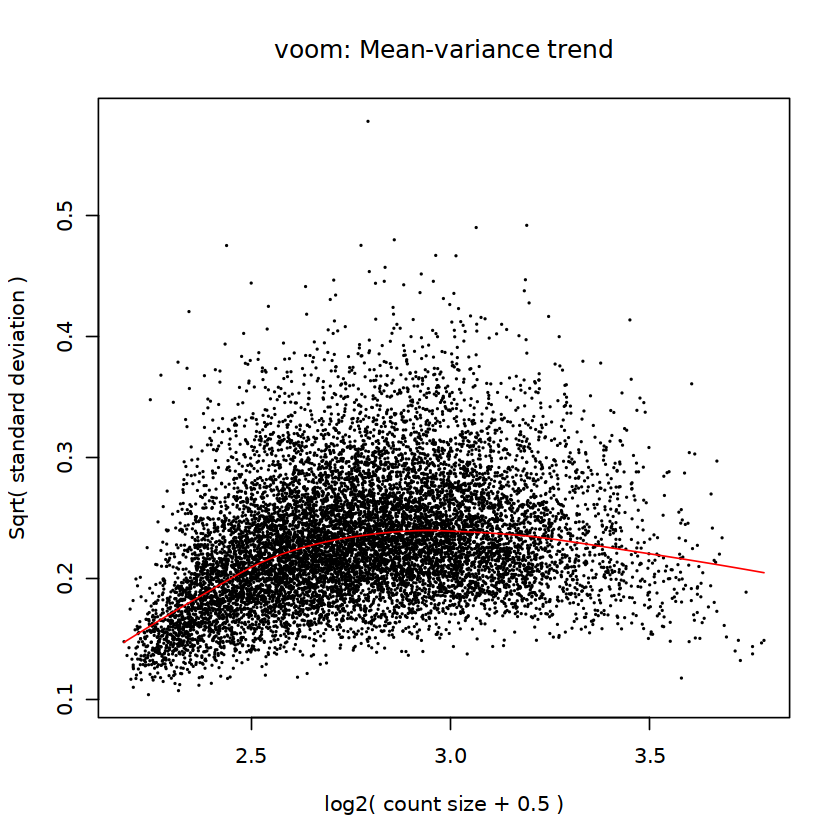

In [21]:
DGElist <- DGEList( counts = data, group = group_list )
keep_gene <- rowSums( cpm(DGElist) > 1 ) >= 1 # 自定义
table(keep_gene)
DGElist <- DGElist[ keep_gene, , keep.lib.sizes = FALSE ]

DGElist <- calcNormFactors( DGElist )
v <- voom(DGElist, design, plot = TRUE, normalize = "quantile")
fit <- lmFit(v, design)
cont.matrix <- makeContrasts(contrasts = c('cluster1-control'), levels = design)

fit2 <- contrasts.fit(fit, cont.matrix)
fit2 <- eBayes(fit2)

nrDEG_limma_voom = topTable(fit2, coef = 'cluster1-control', n = Inf)
nrDEG_limma_voom = na.omit(nrDEG_limma_voom)
head(nrDEG_limma_voom)

In [22]:
padj = 0.01 # 自定义
foldChange= 0 # 自定义
nrDEG_limma_voom_signif = nrDEG_limma_voom[(nrDEG_limma_voom$adj.P.Val < padj & 
                          (nrDEG_limma_voom$logFC>foldChange | nrDEG_limma_voom$logFC<(-foldChange))),]
nrDEG_limma_voom_signif = nrDEG_limma_voom_signif[order(nrDEG_limma_voom_signif$logFC),]

In [23]:
dim(nrDEG_limma_voom_signif)

[1] 375   6

In [24]:
library(cowplot)
library(pheatmap)
library(enrichplot)
library(clusterProfiler)
library(org.Hs.eg.db)

Warning message:
"package 'cowplot' was built under R version 4.2.3"
Warning message:
"package 'pheatmap' was built under R version 4.2.3"
Warning message:
"package 'enrichplot' was built under R version 4.2.2"


Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidyt

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(geneID = rownames(nrDEG_limma_voom_signif), fromType = "SYMBOL", :
"0.27% of input gene IDs are fail to map..."
Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
"Use 'cex.params = list(category_label = your_value)' instead of 'cex_label_category'.
 The cex_label_category parameter will be removed in the next version."
Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
"Use 'cex.params = list(line = your_value)' instead of 'cex_line'.
 The cex_line parameter will be removed in the next version."
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


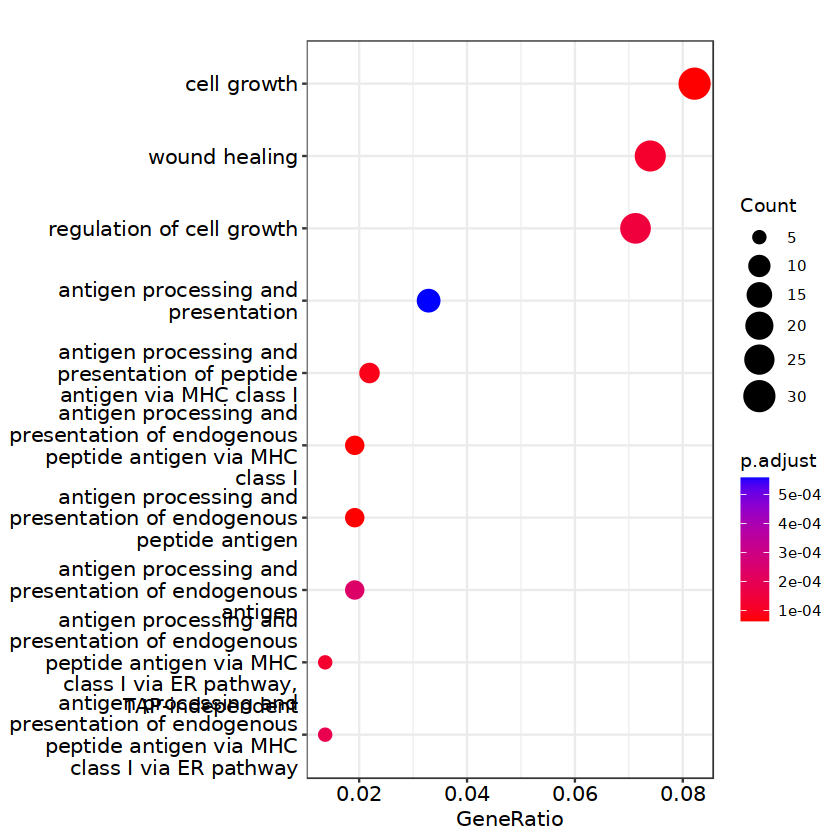

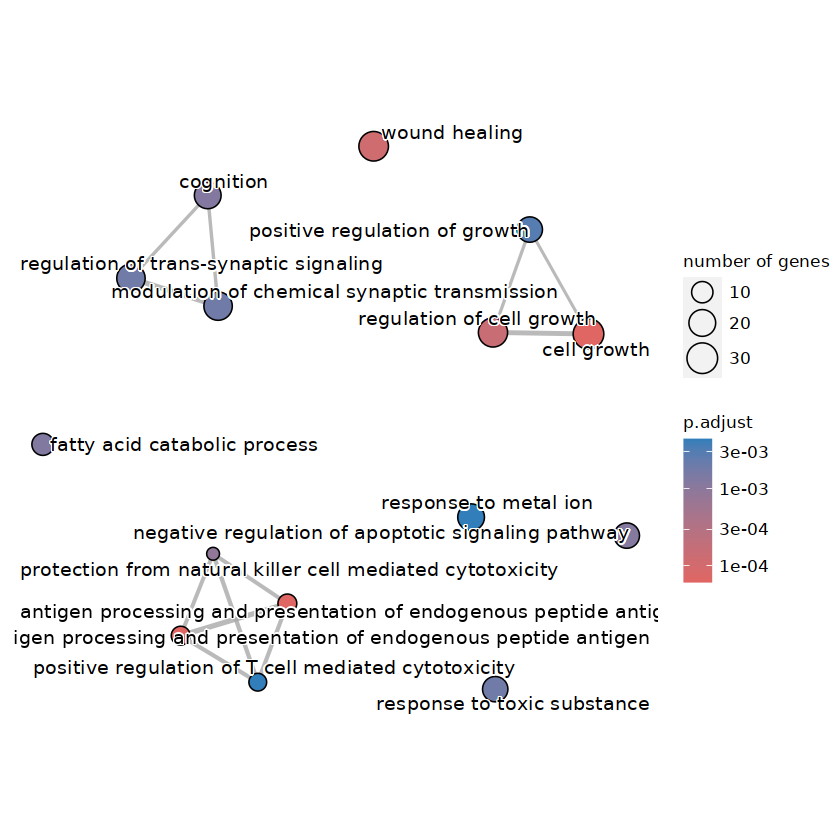

In [25]:
gene_symbol <- bitr(geneID = rownames(nrDEG_limma_voom_signif),  
                        fromType="SYMBOL",   
                        toType=c("ENTREZID"),  
                        OrgDb="org.Hs.eg.db")
    gene <- gene_symbol[,2]
    BP <- enrichGO(gene = gene,  
                   keyType = "ENTREZID",  
                   OrgDb=org.Hs.eg.db,  
                   ont = "BP",   
                   pvalueCutoff = 0.05,  
                   pAdjustMethod = "fdr", 
                   minGSSize = 5,   
                   maxGSSize = 500,  
                   qvalueCutoff = 0.05,  
                   readable = TRUE)  
    
    dotplot(BP,showCategory = 10)
    #ggsave('GO_enrichment_dotplot.pdf',height = 15,width = 8)
    bp <-clusterProfiler::simplify(BP)
    BP_ego <- enrichplot::pairwise_termsim(bp)
    emapplot(BP_ego, cex_label_category=.8, cex_line=.5,showCategory = 15) + 
      ggplot2::scale_fill_continuous(low = "#e06663", high = "#327eba", name = "p.adjust",
                            guide = ggplot2::guide_colorbar(reverse = TRUE, order=2.5), trans='log10')
    #ggsave('GO_enrichment_emapplot.pdf',height = 15,width = 8)
    df <- BP_ego@result
   # write.csv(df ,file = 'GO_results.csv')

Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...

Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
"Use 'cex.params = list(category_label = your_value)' instead of 'cex_label_category'.
 The cex_label_category parameter will be removed in the next version."
Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
"Use 'cex.params = list(line = your_value)' instead of 'cex_line'.
 The cex_line parameter will be removed in the next version."
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


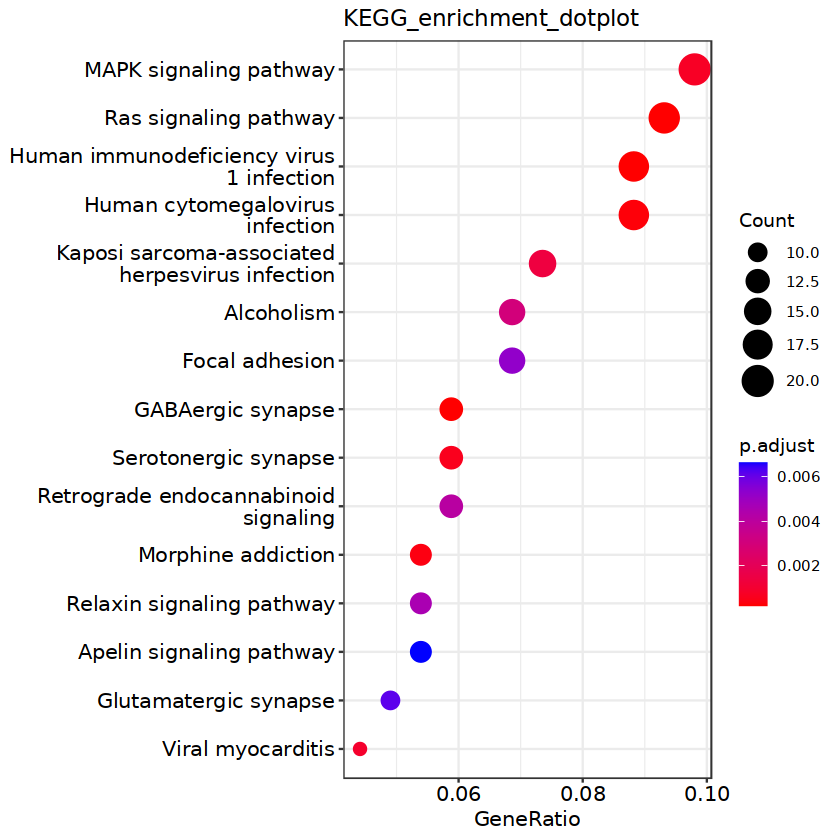

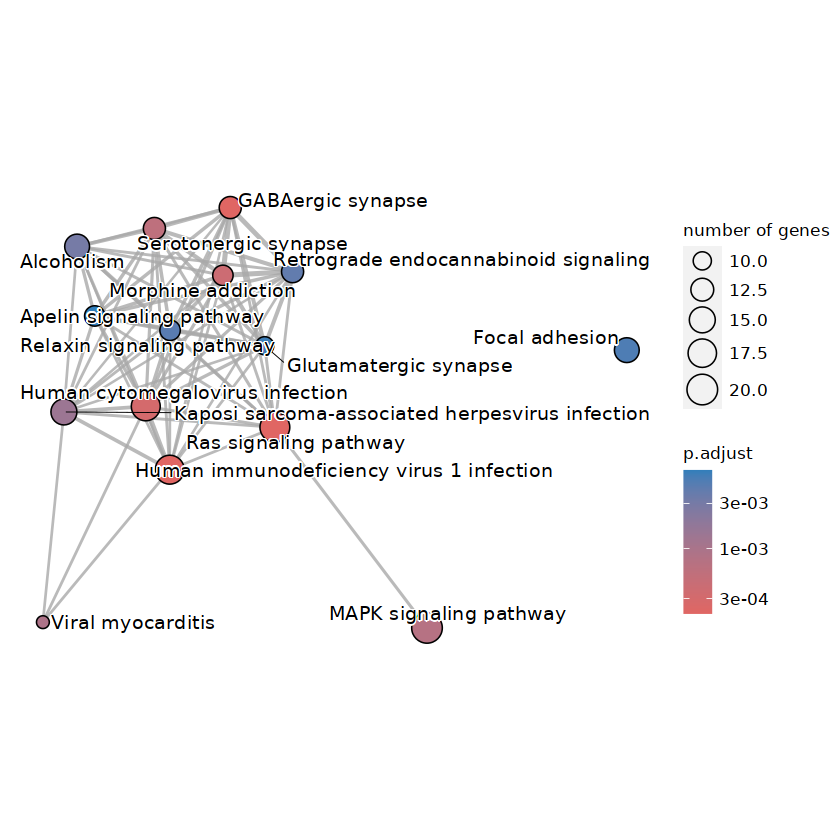

In [76]:
ek <- enrichKEGG(gene =gene , 
                   organism = "hsa",  
                   pvalueCutoff =1, 
                   qvalueCutoff = 1) 
    keggres = ek@result
    #write.csv(keggres,file = 'kegg_results.csv')
    enrichplot::dotplot(ek,  
            x = "GeneRatio", 
            color = "p.adjust", 
            showCategory = 15, 
            size = 'Count', 
            title = "KEGG_enrichment_dotplot"  
            )
   # ggsave('KEGG_enrichment_dotplot.pdf',height = 6,width = 6)
    KEGG2 <- pairwise_termsim(ek)
    emapplot(KEGG2, cex_label_category=.8, cex_line=.5,showCategory = 15) + 
      ggplot2::scale_fill_continuous(low = "#e06663", high = "#327eba", name = "p.adjust",
                            guide = ggplot2::guide_colorbar(reverse = TRUE, order=2.5), trans='log10')
   # ggsave('KEGG_enrichment_net.pdf',height = 8,width = 8)   